<a href="https://colab.research.google.com/github/neelkanthrawat/Course_Computational_statistics_and_data_analysis/blob/main/Exercise_8_Heteroskedastic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import sklearn
from sklearn.model_selection import train_test_split

In [4]:
path='/content/data_09_x_y.csv'
df=pd.read_csv(path)

In [15]:
df

x         y
0   -20.00000 -1.064822
1   -19.91992 -1.579783
2   -19.83984 -1.215242
3   -19.75976 -1.133058
4   -19.67968 -0.917498
..        ...       ...
995  59.67968  4.639976
996  59.75976  3.174017
997  59.83984  6.610470
998  59.91992  6.352328
999  60.00000  5.726463

[1000 rows x 2 columns]

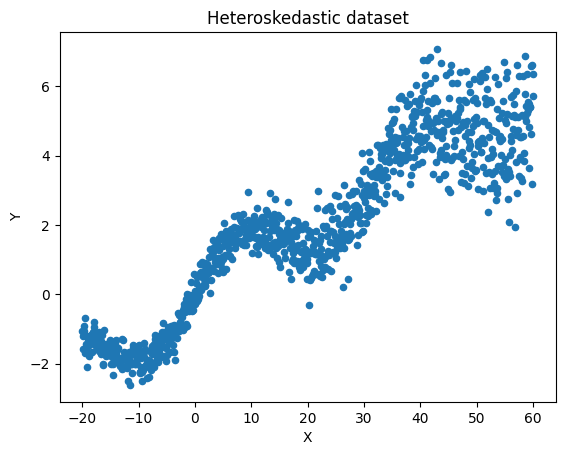

In [6]:
df.plot(x='x',y='y', kind='scatter')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heteroskedastic dataset')
plt.show()

In [7]:
xval, yval=df['x'].values, df['y'].values
xval.shape, yval.shape, type(yval)

((1000,), (1000,), numpy.ndarray)

In [8]:
xval, yval =np.array(xval).reshape(-1,1), np.array(yval).reshape(-1,1)
xval.shape, yval.shape

((1000, 1), (1000, 1))

In [9]:
random_state=42
x_train, x_test, y_train, y_test = train_test_split(xval, yval, test_size=0.33, random_state=random_state)

In [10]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((670, 1), (330, 1), (670, 1), (330, 1))

# 3.(b)

1. Creating a *MLP*

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim

def train_and_validate(model, train_loader, val_loader,device,
                       num_epochs=10, lr=0.001,
                       print_after=2):

    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    #
    train_losses=[]
    val_losses=[]

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # save the losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % print_after == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} => Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    print("Training finished.")

    return train_losses, val_losses

In [13]:
# Create an instance of the MLP model
mlp_model = MLP()

# Print the architecture of the model
print(mlp_model)

MLP(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [16]:
class data_for_regression(torch.utils.data.Dataset):
  def __init__ (self, x, y):
    self.x=x
    self.y=y

  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

In [17]:
### create the dataloaders

#1. converting to torch
x_trn_torch=torch.Tensor(x_train).float()
x_test_torch=torch.Tensor(x_test).float()
y_trn_torch=torch.Tensor(y_train).float()
y_test_torch=torch.Tensor(y_test).float()

train_dataset= data_for_regression(x_trn_torch, y_trn_torch)
test_dataset= data_for_regression(x_test_torch, y_test_torch)

batch_size=32
train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader= torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [23]:
def plot_train_and_val_loss(train_loss, val_loss, want_logscale=True):

  plt.plot(train_loss,"-",label="train loss")
  plt.plot(val_loss, ":", label="val loss")

  plt.xlabel("epochs")
  plt.ylabel("average epoch loss")

  if want_logscale:
    plt.yscale('log')
  plt.legend()

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_3b=MLP()

train_loss, test_loss=train_and_validate(model_3b,train_loader=train_dataloader,
                                         device=device,
                                         val_loader=tst_dataloader, num_epochs=5000, lr=0.0002,
                                         print_after=500)

plot_train_and_val_loss(train_loss, test_loss)

Epoch 500/5000 => Training Loss: 0.677811107465199, Validation Loss: 0.6912089261141691
Epoch 1000/5000 => Training Loss: 0.6723836532660893, Validation Loss: 0.6783944097432223


KeyboardInterrupt: 